# 1. Overall density profile of a given year NOT USED JUST MAYBE FOR LATER

To be in accordance with TEOS-10 it translates from Salinity_[psu] & Temp_[°C] into Absolute_Salinity [g/kg] & Conservative_Temp_deg [°C]. As sources I used the TEOS-10 book, some ChatGPT, lots of StackOverflow or Python Library Documentations (which I can easily quote), and also Work/Study coding experience for which giving sources like "my own memory" isnt feasible.

I did later integrate this into the buoyancy frequency calculation. But I saved it here because I initially thought to code them all in individual cells.

This cell stands like a mausoleum in the notebook. An empty monument to purpose lost. Its imports now hollow echoes of once-needed power, its functions ghosts repeating a ritual whose god has died. Nothing calls it, nothing depends on it, and yet it remains, proud and decaying, a cathedral of abandoned syntax that pretends to matter while the living code has already moved on. The later cells no longer look back; the computations no longer seek its guidance. It endures only as a relic. Proof that even in the cold precision of programming, obsolescence can linger like grief, and a script can keep breathing long after its heart has stopped.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Paths
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_1980.txt")
OUTPUT_DIR = Path("Density")
MISSING_VALUE = -999.0

# Finding the year within the txt
def _infer_year_from_timestamp(series: pd.Series) -> str:
    """Try to infer a year from the yyyy-mm-ddThh:mm column."""
    s = series.dropna().astype(str)
    if s.empty:
        return "unknown"
    first = s.iloc[0]
    try:
        return str(pd.to_datetime(first).year)
    except Exception:
        return str(first)[:4]

# Read raw UDASH file
def process_udash_file(path: Path, output_dir: Path = OUTPUT_DIR) -> tuple[pd.DataFrame, Path]:
    df = pd.read_csv(
        path,
        delim_whitespace=True,
        na_values=[MISSING_VALUE],
        engine="python",
    )

    # Replace explicit missing flag just in case
    df = df.replace(MISSING_VALUE, np.nan)

    # Make sure key columns exist
    required_cols = [
        "Prof_no",
        "Cruise",
        "Station",
        "Platform",
        "Type",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in UDASH file: {missing}")

    # Sort so casts stay together and levels are ordered
    sort_keys = [
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Depth_[m]",
        "Pressure_[dbar]",
    ]
    sort_keys = [k for k in sort_keys if k in df.columns]
    df = df.sort_values(sort_keys).reset_index(drop=True)

    # TEOS-10 inputs
    SP = df["Salinity_[psu]"].to_numpy(float)
    t = df["Temp_[°C]"].to_numpy(float)
    p = df["Pressure_[dbar]"].to_numpy(float)
    lon = df["Longitude_[deg]"].to_numpy(float)
    lat = df["Latitude_[deg]"].to_numpy(float)

    # ChatGPT: Range-based masking
    def _mask_range(arr, lo, hi):
        bad = (arr < lo) | (arr > hi)
        arr = arr.copy()
        arr[bad] = np.nan
        return arr

    lat = _mask_range(lat, -90, 90)
    lon = _mask_range(lon, -180, 360)
    p = _mask_range(p, 0, 12000)
    SP = _mask_range(SP, 0, 50)
    t = _mask_range(t, -5, 40)

    # TEOS-10 computations
    SA = gsw.SA_from_SP(SP, p, lon, lat)           # Absolute salinity [g/kg]
    CT = gsw.CT_from_t(SA, t, p)                   # Conservative temperature [°C]
    rho = gsw.rho(SA, CT, p)                       # In-situ density [kg/m³]
    sigma0 = gsw.sigma0(SA, CT) + 1000.0           # Potential density σ0 + 1000

    # Attach TEOS-10 variables + source_file
    df = df.copy()
    df.insert(0, "source_file", path.name)
    df["Absolute_Salinity_g_kg"] = SA
    df["Conservative_Temp_degC"] = CT
    df["Density_kg_m3"] = rho
    df["Potential_Density_kg_m3"] = sigma0

    # Build output path with year tag
    year = _infer_year_from_timestamp(df["yyyy-mm-ddThh:mm"])
    output_dir.mkdir(parents=True, exist_ok=True)
    out_path = output_dir / f"{year}_{path.stem}_teos10.txt"

    # Choose column order for TEOS-10 file 
    out_cols = [
        "source_file",
        "Prof_no",
        "Cruise",
        "Station",
        "Platform",
        "Type",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
        "Potential_Density_kg_m3",
    ]
    out_cols = [c for c in out_cols if c in df.columns]

    # Write nicely sorted TEOS-10 file
    df[out_cols].to_csv(
        out_path,
        sep="\t",
        index=False,
        float_format="%.6f",
    )

    print(f"Loaded {len(df)} rows from {path}")
    print(f"TEOS-10 file written to: {out_path}")
    return df, out_path


# EXECUTION
df_teos10, teos10_path = process_udash_file(UDASH_FILE)

# Show a quick preview
df_teos10.head()


/tmp/ipykernel_14925/4065537479.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loaded 299216 rows from UDASH/ArcticOcean_phys_oce_1980.txt
TEOS-10 file written to: Density/1980_ArcticOcean_phys_oce_1980_teos10.txt


,source_file,Prof_no,Cruise,Station,Platform,Type,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],...,Salinity_[psu],QF.2,Source,DOI,WOD-Cruise-ID,WOD-Cast-ID,Absolute_Salinity_g_kg,Conservative_Temp_degC,Density_kg_m3,Potential_Density_kg_m3
0,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,0.0,...,34.956,0,ices,NaN,NaN,NaN,35.122560,3.825470,1027.770495,1027.770495
1,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,5.0,...,34.955,0,ices,NaN,NaN,NaN,35.121586,3.835130,1027.792000,1027.768730
2,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,10.0,...,34.958,0,ices,NaN,NaN,NaN,35.124631,3.824773,1027.818743,1027.772204
3,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,15.0,...,34.957,0,ices,NaN,NaN,NaN,35.123624,3.824445,1027.841245,1027.771441
4,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,20.0,...,34.952,0,ices,NaN,NaN,NaN,35.118597,3.824156,1027.860563,1027.767495


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Path
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_1980.txt")
TEOS_DIR = Path("Density")
N2_DIR = Path("N2")

# ChatGPT: Find the TEOS-10 file produced earlier, since I might have to change paths later
pattern = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern} in {TEOS_DIR}")
TEOS10_FILE = teos_files[0]

# Load TEOS-10 data
df = pd.read_csv(TEOS10_FILE, sep="\t")

def compute_N2_for_cast(g: pd.DataFrame) -> pd.DataFrame | None:
    """Compute N² for a single cast, keeping metadata."""
    g = g.sort_values("Pressure_[dbar]").dropna(
        subset=["Absolute_Salinity_g_kg", "Conservative_Temp_degC",
                "Density_kg_m3", "Pressure_[dbar]", "Latitude_[deg]"]
    )
    if len(g) < 3:
        return None
    # gsw only takes floating point numbers, gotta convert them
    SA = g["Absolute_Salinity_g_kg"].to_numpy(float)
    CT = g["Conservative_Temp_degC"].to_numpy(float)
    p = g["Pressure_[dbar]"].to_numpy(float)
    rho = g["Density_kg_m3"].to_numpy(float)
    lat = float(g["Latitude_[deg]"].iloc[0])

    # N2 and mid-pressure as gsw is defined
    N2, p_mid = gsw.Nsquared(SA, CT, p, lat)
    if N2.size == 0:
        return None

    z_mid = -gsw.z_from_p(p_mid, lat)  # positive depth
    SA_mid = 0.5 * (SA[:-1] + SA[1:])
    CT_mid = 0.5 * (CT[:-1] + CT[1:])
    rho_mid = 0.5 * (rho[:-1] + rho[1:])

    # construct columns again
    first = g.iloc[0]
    return pd.DataFrame({
        "source_file": first["source_file"],
        "Prof_no": first["Prof_no"],
        "Cruise": first["Cruise"],
        "Station": first["Station"],
        "Platform": first["Platform"],
        "Type": first["Type"],
        "yyyy-mm-ddThh:mm": first["yyyy-mm-ddThh:mm"],
        "Longitude_[deg]": first["Longitude_[deg]"],
        "Latitude_[deg]": first["Latitude_[deg]"],
        "Pressure_[dbar]": p_mid,
        "Depth_[m]": z_mid,
        "Absolute_Salinity_[g/kg]": SA_mid,
        "Conservative_Temperature_[°C]": CT_mid,
        "In-situ_Density_[kg m^-3]": rho_mid,
        "N2_[s^-2]": N2,
    })

# Compute N2 for all casts
pieces = []
for pid, gcast in df.groupby("Prof_no"):
    out = compute_N2_for_cast(gcast)
    if out is not None:
        pieces.append(out)
# Error message so as not to just get a Python error
if not pieces:
    raise RuntimeError("No valid casts for N² computation.")

# ChatGPT: I dont know but it wont run without this line
dfN2 = pd.concat(pieces, ignore_index=True)

# Ensure sorting: by profile, then depth, then pressure
dfN2 = dfN2.sort_values(
    ["Prof_no", "Depth_[m]", "Pressure_[dbar]"]
).reset_index(drop=True)

# Build output path and save
N2_DIR.mkdir(parents=True, exist_ok=True)
year_tag = TEOS10_FILE.stem.split("_", 1)[0]  # e.g. "1980"
out_path = N2_DIR / f"N2_{year_tag}_{UDASH_FILE.stem}.txt"

cols_out = [
    "source_file",
    "Prof_no",
    "Cruise",
    "Station",
    "Platform",
    "Type",
    "yyyy-mm-ddThh:mm",
    "Longitude_[deg]",
    "Latitude_[deg]",
    "Pressure_[dbar]",
    "Depth_[m]",
    "Absolute_Salinity_[g/kg]",
    "Conservative_Temperature_[°C]",
    "In-situ_Density_[kg m^-3]",
    "N2_[s^-2]",
]
cols_out = [c for c in cols_out if c in dfN2.columns]

dfN2[cols_out].to_csv(
    out_path,
    sep="\t",
    index=False,
    float_format="%.6e",
)

print(f"Computed N² for {dfN2['Prof_no'].nunique()} casts "
      f"({len(dfN2)} midpoints).")
print(f"N² file written to: {out_path}")

dfN2.head()


/tmp/ipykernel_14925/1719737840.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TEOS10_FILE, sep="\t")


Computed N² for 6235 casts (275381 midpoints).
N² file written to: N2/N2_1980_ArcticOcean_phys_oce_1980.txt


,source_file,Prof_no,Cruise,Station,Platform,Type,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],Depth_[m],Absolute_Salinity_[g/kg],Conservative_Temperature_[°C],In-situ_Density_[kg m^-3],N2_[s^-2]
0,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,2.5,2.474301,35.122073,3.830300,1027.781248,-0.000003
1,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,7.5,7.422813,35.123109,3.829951,1027.805372,0.000007
2,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,12.5,12.371205,35.124128,3.824609,1027.829994,-0.000001
3,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,17.5,17.319477,35.121111,3.824300,1027.850904,-0.000008
4,ArcticOcean_phys_oce_1980.txt,490,G.O._SARS,0158,S,B,1980-01-29T13:00,27.035,72.692,22.5,22.267629,35.121147,3.833947,1027.873195,0.000004


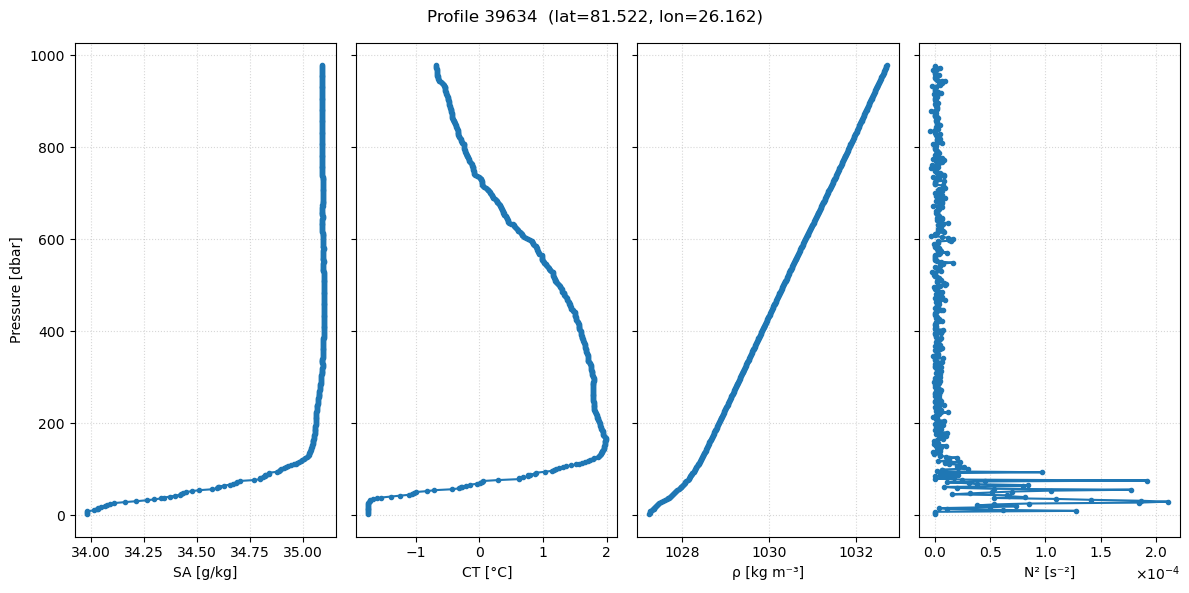

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# choose which cast to plot
profile_id = 39634

# TEOS-10 variables for this cast
g_teos = (
    df_teos10[df_teos10["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

# N2 for this cast
g_n2 = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

p = g_teos["Pressure_[dbar]"].to_numpy()
SA = g_teos["Absolute_Salinity_g_kg"].to_numpy()
CT = g_teos["Conservative_Temp_degC"].to_numpy()
rho = g_teos["Density_kg_m3"].to_numpy()

p_mid = g_n2["Pressure_[dbar]"].to_numpy()
N2v = g_n2["N2_[s^-2]"].to_numpy()

fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

axes[0].plot(SA, p, marker=".")
axes[0].set_xlabel("SA [g/kg]")
axes[0].set_ylabel("Pressure [dbar]")

axes[1].plot(CT, p, marker=".")
axes[1].set_xlabel("CT [°C]")

axes[2].plot(rho, p, marker=".")
axes[2].set_xlabel("ρ [kg m⁻³]")

axes[3].plot(N2v, p_mid, marker=".")
axes[3].set_xlabel("N² [s⁻²]")

# exponential notation for N2 axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
axes[3].xaxis.set_major_formatter(formatter)
axes[3].ticklabel_format(style="sci", axis="x", scilimits=(-3, 3))

for ax in axes:
    ax.invert_yaxis()
    ax.grid(True, linestyle=":", alpha=0.5)

lat = g_teos["Latitude_[deg]"].iloc[0]
lon = g_teos["Longitude_[deg]"].iloc[0]
fig.suptitle(f"Profile {profile_id}  (lat={lat:.3f}, lon={lon:.3f})", y=0.98)

plt.tight_layout()
plt.show()


/tmp/ipykernel_14925/3819587097.py:60: RuntimeWarning: Mean of empty slice
  mean_N2 = np.nanmean(N2_stack, axis=0)
/home/conda/envs/ocean/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


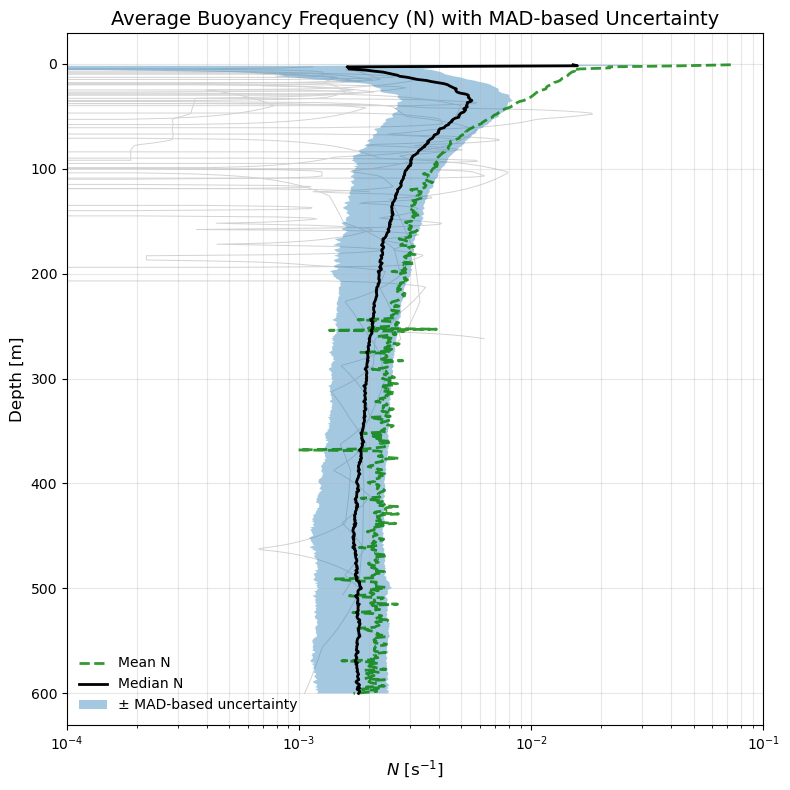

Using 6048 casts.
Saved average-N figure with uncertainty to /home/rill/D_figs/1980-Average_N_with_uncertainty.png


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from pathlib import Path

# infer year tag from timestamps or fallback 
year_tag = "all"
if "yyyy-mm-ddThh:mm" in dfN2.columns:
    try:
        ts = (
            pd.to_datetime(dfN2["yyyy-mm-ddThh:mm"]
            .dropna()
            .astype(str)
            .iloc[0])
        )
        year_tag = str(ts.year)
    except Exception:
        pass
elif "source_file" in dfN2.columns:
    import re
    m = re.search(r"(\d{4})", str(dfN2["source_file"].iloc[0]))
    if m:
        year_tag = m.group(1)

# find casts (by Prof_no, no mixing of casts)
if "Prof_no" not in dfN2.columns:
    raise ValueError("dfN2 does not contain 'Prof_no'; cannot separate casts cleanly.")
cast_ids = dfN2["Prof_no"].unique()

# define common depth grid (m) 
comparison_depth = np.arange(0, 600 + 1, 1)  # 0–600 m in 1 m steps

# build N2 stack per cast on common depth grid 
N2_stack = []
for cid in cast_ids:
    subset = dfN2[dfN2["Prof_no"] == cid].dropna(subset=["Depth_[m]", "N2_[s^-2]"])
    if len(subset) < 3:
        continue

    z = subset["Depth_[m]"].to_numpy(float)
    N2_vals = subset["N2_[s^-2]"].to_numpy(float)

    # sort by depth within cast
    order = np.argsort(z)
    z, N2_vals = z[order], N2_vals[order]

    # require increasing depth for interpolation
    if np.all(np.diff(z) <= 0):
        continue

    N2_interp = np.interp(comparison_depth, z, N2_vals, left=np.nan, right=np.nan)
    N2_stack.append(N2_interp)

N2_stack = np.array(N2_stack)
if N2_stack.size == 0:
    raise RuntimeError("No valid casts with N² data found in dfN2.")

# statistics across casts (per depth)
mean_N2 = np.nanmean(N2_stack, axis=0)
median_N2 = np.nanmedian(N2_stack, axis=0)
mad_N2 = np.nanmedian(np.abs(N2_stack - median_N2), axis=0)  # MAD in N²

median_N = np.sqrt(np.clip(median_N2, 0, np.inf))
mean_N = np.sqrt(np.clip(mean_N2, 0, np.inf))

# Pinner et al: propagate MAD in N2 to an uncertainty in N
with np.errstate(divide="ignore", invalid="ignore"):
    delta_N_mad = 0.5 * mad_N2 / np.where(median_N > 0, median_N, np.nan)

# create figure 
fig, ax = plt.subplots(figsize=(8, 8))

# plot random subset of individual casts in light grey
num_samples = min(8, len(N2_stack))
sample_idx = np.random.choice(len(N2_stack), num_samples, replace=False)
for row in N2_stack[sample_idx]:
    N_row = np.sqrt(np.clip(row, 0, np.inf))
    ax.plot(N_row, comparison_depth, color="lightgrey", lw=0.7, zorder=1)

# mean & median N
ax.plot(mean_N, comparison_depth, "g--", lw=2, alpha=0.8, label="Mean N")
ax.plot(median_N, comparison_depth, "k", lw=2, label="Median N")

# uncertainty band (MAD-based)
ax.fill_betweenx(
    comparison_depth,
    median_N - delta_N_mad,
    median_N + delta_N_mad,
    alpha=0.4,
    label="± MAD-based uncertainty",
)

# x-axis: LOG scale
ax.set_xscale("log")
ax.set_xlim(1e-4, 1e-1)
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=8))
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.invert_yaxis()
ax.set_xlabel(r"$N$ [s$^{-1}$]", fontsize=12)
ax.set_ylabel("Depth [m]", fontsize=12)
ax.set_title("Average Buoyancy Frequency (N) with MAD-based Uncertainty", fontsize=14)
ax.grid(True, which="both", alpha=0.3)
ax.legend(frameon=False, loc="best")

plt.tight_layout()

# save PNG per year in D_figs
fig_dir = Path("D_figs")
fig_dir.mkdir(parents=True, exist_ok=True)
out_path = fig_dir / f"{year_tag}-Average_N_with_uncertainty.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")

plt.show()
print(f"Using {len(N2_stack)} casts.")
print(f"Saved average-N figure with uncertainty to {out_path.resolve()}")



# 3. Creating the Eigenvalue Problem

This will need a few days of literature recherche and reading into, as we are now entering the not so well documented realms. PDF sources are stored locally again

Non PDF Sources:
- https://gist.github.com/douglatornell/5479638
- https://github.com/OceanLabPy/OceanLab/blob/master/examples/DYN_EOF.ipynb    (not this example, but maybe DYN.vmodes(...)
- https://github.com/UBC-MOAD/AIMS-Workshop/blob/main/dynmodes/dynmodes.ipynb   (is a newer refined version, could be changed to work)
- "Fast and Accurate Computation of Vertical Modes" Early et.al. 2020 could help too, since I literally have worked with spectral methods and Chebyshev Polynomials befor
- Chelton et.al. 1998 still is really helpful
- "The Vertical Mode Decomposition of Surface and Internal Tides in the Presence of a Free Surface and Arbitrary Topography" by Samuel L. Kelly 2016, although here I wonder if his assumptions even remotely agree with mine


Furthermore, the large errors and variations of the Buoyancy Frequency in the upper meters call for caution due to error propagation.

In [131]:
# ===================== ALL CASTS from big UDASH-like .txt → c1..c3 =====================
# Robust segmentation + diagnostics, then Chelton-style EVP per cast.
# ---------------------------------------------------------------------------------------
import os, re, glob, warnings
import numpy as np
import pandas as pd
from typing import Optional, Tuple, List, Iterable
from scipy.linalg import eigh

# ---------------------------- SETTINGS (tune here) ------------------------------------
TXT_PATHS     = ["Buoyancy_Freq/N2_1980.txt"]     # list of files OR use folder scan below
# TXT_PATHS   = sorted(glob.glob("Buoyancy_Freq/**/*.txt", recursive=True))

OUT_DIR       = "eigenspeeds"     # <--- output folder
os.makedirs(OUT_DIR, exist_ok=True)

# EVP parameters
NMODES        = 3
DZ            = 10.0               # uniform remesh (m)
SMOOTH_WIN    = 5                  # odd >=3, else disable
N2_FLOOR      = 1e-8

# Segmentation parameters
MIN_LEVELS    = 12                 # minimum points per cast
MIN_SPAN_M    = 40.0               # min depth range
EPS_DEPTH     = 0.5                # treat depth drop > EPS_DEPTH as new cast
EPS_LAT       = 1e-5               # ~1e-5 deg ~ 1 m; raise to 1e-4 if coords are noisy
EPS_LON       = 1e-5

# Column names in your file (as per your example)
DEPTH_COLS = ["Depth_[m]", "Depth_m", "z_mid", "depth", "z"]
N2_COLS    = ["N2_[s^-2]", "N2_s^-2", "N2", "n2"]
PID_COLS   = ["Prof_no", "profile", "cast", "cast_id"]
LON_COLS   = ["Longitude_[deg]", "lon", "Longitude"]
LAT_COLS   = ["Latitude_[deg]",  "lat", "Latitude"]

# --------------------------- read + column finder --------------------------------------
def _find_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns: return c
    low = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in low: return low[c.lower()]
    return None

def read_udash_txt(path: str) -> pd.DataFrame:
    # try comma first; if single col, let pandas sniff
    try:
        df = pd.read_csv(path)
        if df.shape[1] == 1:
            df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = pd.read_csv(path, sep=None, engine="python")

    dcol = _find_col(df, DEPTH_COLS)
    ncol = _find_col(df, N2_COLS)
    if dcol is None or ncol is None:
        raise ValueError(f"Missing depth/N2 columns in {os.path.basename(path)}")

    out = pd.DataFrame({
        "depth": pd.to_numeric(df[dcol], errors="coerce"),
        "N2":    pd.to_numeric(df[ncol], errors="coerce"),
    })
    pid = _find_col(df, PID_COLS)
    lon = _find_col(df, LON_COLS)
    lat = _find_col(df, LAT_COLS)
    if pid: out["pid"] = df[pid]
    if lon: out["lon"] = pd.to_numeric(df[lon], errors="coerce")
    if lat: out["lat"] = pd.to_numeric(df[lat], errors="coerce")

    out = out.dropna(subset=["depth","N2"])
    return out

# ------------------------------- segmentation ----------------------------------------
def make_cast_ids(depth: np.ndarray,
                  lat: Optional[np.ndarray],
                  lon: Optional[np.ndarray],
                  eps_depth: float,
                  eps_lat: float,
                  eps_lon: float) -> np.ndarray:
    """
    New cast when depth decreases by > eps_depth OR |Δlat|>eps_lat OR |Δlon|>eps_lon.
    Returns integer cast ids [0..K-1] for the rows, assuming rows are time-ordered.
    """
    n = depth.size
    breaks = np.zeros(n, dtype=bool)
    breaks[0] = True
    for i in range(1, n):
        d_drop = (depth[i] + eps_depth) < depth[i-1]    # robust decrease
        ll_jump = False
        if lat is not None and np.isfinite(lat[i]) and np.isfinite(lat[i-1]):
            if abs(lat[i] - lat[i-1]) > eps_lat:
                ll_jump = True
        if lon is not None and np.isfinite(lon[i]) and np.isfinite(lon[i-1]):
            if abs(lon[i] - lon[i-1]) > eps_lon:
                ll_jump = True
        if d_drop or ll_jump:
            breaks[i] = True
    # cumulative sum of breaks gives cast ids
    return np.cumsum(breaks) - 1

def iter_casts(df: pd.DataFrame) -> Iterable[Tuple[int, pd.DataFrame]]:
    """Yield (cast_id, df_cast) after robust segmentation and filtering."""
    df = df.copy()
    # Ensure positive-down depth
    if df["depth"].mean() < 0:
        df["depth"] = -df["depth"]
    df = df.reset_index(drop=True)

    # If there is a provided pid, use it; else construct one
    if "pid" in df.columns:
        cast_ids = pd.factorize(df["pid"], sort=False)[0]
    else:
        lat = df["lat"].to_numpy() if "lat" in df.columns else None
        lon = df["lon"].to_numpy() if "lon" in df.columns else None
        cast_ids = make_cast_ids(df["depth"].to_numpy(), lat, lon,
                                 eps_depth=EPS_DEPTH, eps_lat=EPS_LAT, eps_lon=EPS_LON)

    df["cast_id"] = cast_ids
    for cid, g in df.groupby("cast_id", sort=False):
        g = g.sort_values("depth")
        if len(g) < MIN_LEVELS:         # filter small
            continue
        if (g["depth"].max() - g["depth"].min()) < MIN_SPAN_M:
            continue
        yield int(cid), g

# ----------------------------- diagnostics -----------------------------------------
def print_segmentation_stats(df: pd.DataFrame, title: str):
    print(f"\n--- Segmentation diagnostics for: {title} ---")
    total_rows = len(df)
    print(f"rows: {total_rows:,}")
    lat = df["lat"].to_numpy() if "lat" in df.columns else None
    lon = df["lon"].to_numpy() if "lon" in df.columns else None
    cids = make_cast_ids(df["depth"].to_numpy(), lat, lon, EPS_DEPTH, EPS_LAT, EPS_LON)
    df_tmp = df.assign(_cid=cids)
    counts = df_tmp.groupby("_cid", sort=False)["depth"].agg(["count","min","max"])
    counts["span"] = counts["max"] - counts["min"]
    print(f"casts detected (before filtering): {counts.shape[0]:,}")
    print("levels per cast: median=", int(counts["count"].median()),
          "min=", int(counts["count"].min()), "max=", int(counts["count"].max()))
    print("depth span (m): median=", float(counts["span"].median()),
          "min=", float(counts["span"].min()), "max=", float(counts["span"].max()))
    valid = counts[(counts["count"] >= MIN_LEVELS) & (counts["span"] >= MIN_SPAN_M)]
    print(f"casts kept (after filters): {valid.shape[0]:,}")
    print("---------------------------------------------------------------------------")

# ------------------------------ eigenproblem ---------------------------------------
def _uniformize_grid(depth_down: np.ndarray, N2: np.ndarray, dz: float) -> Tuple[np.ndarray, np.ndarray]:
    z = np.asarray(depth_down, float).ravel()
    if np.nanmean(z) < 0:
        z = -z
    N2 = np.asarray(N2, float).ravel()
    ok = np.isfinite(z) & np.isfinite(N2)
    z, N2 = z[ok], N2[ok]
    order = np.argsort(z)
    z, N2 = z[order], N2[order]
    H = float(np.nanmax(z))
    m = int(np.floor(H/dz)) + 1
    if m < 5:
        raise ValueError("Grid too shallow/coarse (need ≥5 levels).")
    z_down_uni = np.linspace(0.0, H, m)
    N2_uni = np.interp(z_down_uni, z, N2)
    return -z_down_uni, N2_uni

def _smooth_box(x: np.ndarray, win: Optional[int]) -> np.ndarray:
    if not win or win < 3: return x
    if win % 2 == 0: win += 1
    pad = win // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    ker = np.ones(win)/win
    return np.convolve(xpad, ker, mode="same")[pad:-pad]

def _assemble_K_M(z_up: np.ndarray, N2: np.ndarray, n2_floor: float):
    N2 = np.maximum(N2, 0.0)
    dz = float(abs(z_up[1] - z_up[0]))
    m = len(z_up)
    ni = m - 2
    if ni < 3:
        raise ValueError("Profile too short; need ≥5 grid points including boundaries.")
    main = (2.0/dz**2) * np.ones(ni)
    off  = (-1.0/dz**2) * np.ones(ni - 1)
    K = np.diag(main) + np.diag(off, 1) + np.diag(off, -1)
    M = np.diag(np.maximum(N2[1:-1], n2_floor))
    return K, M

def solve_modes(depth_m: np.ndarray, N2_s2: np.ndarray,
                nmodes: int = 3, dz: float = 10.0,
                smooth_win: Optional[int] = 5, n2_floor: float = 1e-8):
    z_up, N2u = _uniformize_grid(depth_m, N2_s2, dz)
    N2u = _smooth_box(N2u, smooth_win)
    K, M = _assemble_K_M(z_up, N2u, n2_floor)
    evals, _ = eigh(K, M)                 # K v = λ M v
    lam = evals[evals > 0][:nmodes]       # λ = 1/c²
    if lam.size < nmodes:
        lam = np.pad(lam, (0, nmodes - lam.size), constant_values=np.nan)
    c = 1.0/np.sqrt(lam)
    return c

# ------------------------------------ RUN -----------------------------------------
for path in TXT_PATHS:
    df = read_udash_txt(path)
    print_segmentation_stats(df, os.path.basename(path))

    all_rows = []
    for cid, g in iter_casts(df):
        try:
            c = solve_modes(g["depth"].to_numpy(), g["N2"].to_numpy(),
                            nmodes=NMODES, dz=DZ, smooth_win=SMOOTH_WIN, n2_floor=N2_FLOOR)
        except Exception as e:
            warnings.warn(f"EVP failed in {os.path.basename(path)} cast #{cid}: {e}")
            continue

        lon = float(g["lon"].median()) if "lon" in g.columns and g["lon"].notna().any() else np.nan
        lat = float(g["lat"].median()) if "lat" in g.columns and g["lat"].notna().any() else np.nan
        row = {
            "src_file": os.path.basename(path),
            "cast_id": int(cid),
            "n_levels": int(len(g)),
            "depth_min_m": float(g["depth"].min()),
            "depth_max_m": float(g["depth"].max()),
            "lon": lon,
            "lat": lat
        }
        for j in range(NMODES):
            row[f"c{j+1}_m_per_s"] = float(c[j]) if np.isfinite(c[j]) else np.nan
        all_rows.append(row)

    out = pd.DataFrame(all_rows)
    # --- determine year from filename ---
    year_match = re.search(r"(19|20)\d{2}", os.path.basename(path))
    year_str = year_match.group(0) if year_match else "unknown"
    out_path = os.path.join(OUT_DIR, f"eigenspeeds_{year_str}.csv")

    out.to_csv(out_path, index=False)
    print(f"\nWrote {len(out)} casts to {out_path}.")
    display(out.head(10))
# =======================================================================================



--- Segmentation diagnostics for: N2_1980.txt ---
rows: 275,494
casts detected (before filtering): 6,272
levels per cast: median= 14 min= 1 max= 1721
depth span (m): median= 235.00050349999998 min= 0.0 max= 5070.599198
casts kept (after filters): 3,482
---------------------------------------------------------------------------

Wrote 3482 casts to eigenspeeds/eigenspeeds_1980.csv.


,src_file,cast_id,n_levels,depth_min_m,depth_max_m,lon,lat,c1_m_per_s,c2_m_per_s,c3_m_per_s
0,N2_1980.txt,0,44,2.47e+00,2.86e+02,-5.87e+00,7.50e+01,1.80e-01,8.25e-02,6.07e-02
1,N2_1980.txt,1,44,2.47e+00,2.85e+02,-5.87e+00,7.50e+01,1.35e-01,9.31e-02,6.64e-02
2,N2_1980.txt,3,46,2.47e+00,3.32e+02,-5.87e+00,7.50e+01,4.44e-01,1.97e-01,1.30e-01
3,N2_1980.txt,4,23,2.47e+00,1.12e+02,-5.87e+00,7.50e+01,7.20e-02,3.56e-02,2.51e-02
4,N2_1980.txt,5,67,2.47e+00,8.50e+02,-5.87e+00,7.50e+01,6.14e-01,3.60e-01,2.43e-01
5,N2_1980.txt,7,34,2.47e+00,1.68e+02,-5.87e+00,7.50e+01,2.70e-01,1.47e-01,9.47e-02
6,N2_1980.txt,10,30,2.47e+00,1.48e+02,-5.87e+00,7.50e+01,2.20e-01,1.02e-01,7.33e-02
7,N2_1980.txt,11,50,2.47e+00,4.31e+02,-5.87e+00,7.50e+01,6.52e-01,2.69e-01,2.03e-01
8,N2_1980.txt,12,38,2.47e+00,1.88e+02,-5.87e+00,7.50e+01,2.85e-01,1.65e-01,1.10e-01
9,N2_1980.txt,13,40,2.47e+00,1.97e+02,-5.87e+00,7.50e+01,3.37e-01,1.63e-01,1.03e-01


# 4. Mapping the results